## AuxTel Astrometry - 14Jun-21

In this notebook, investigate astrometry from 09-Jun-21

In [2]:
import sys, time, os, asyncio, glob

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle as pkl
import pandas as pd
import astropy.io.fits as pf
from astropy.time import Time, TimeDelta
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u
from astropy.table import Table
from astroquery.astrometry_net import AstrometryNet

from lsst.daf.butler import Butler as gen3Butler
from lsst.daf.persistence import Butler as gen2Butler
from lsst_efd_client import EfdClient
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

In [3]:
# Set Cerro Pachon location
location = EarthLocation.from_geodetic(lon=-70.749417*u.deg,
                                       lat=-30.244639*u.deg,
                                       height=2663.0*u.m)


In [9]:
# Now get the image data

expId = 2021060900352
# Get the raw quickLook data.  Only Gen2 works for now
REPO_DIR = '/project/shared/auxTel/rerun/quickLook'

gen2_butler = gen2Butler(REPO_DIR)
charConfig = CharacterizeImageConfig()
charConfig.doMeasurePsf = False#True
charConfig.doApCorr = False
charConfig.doDeblend = False
charConfig.repair.doCosmicRay = True
charConfig.repair.doInterpolate = True   
charConfig.detection.minPixels = 500
charTask = CharacterizeImageTask(config=charConfig)


exp = gen2_butler.get('quickLookExp', detector=0, expId=expId)
mData = exp.getMetadata()
charResult = charTask.run(exp)
sourceCatalog = charResult.sourceCat
maxFlux = np.nanmax(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'])
selectBrightestSource = sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.99
brightestSource = sourceCatalog.subset(selectBrightestSource)
brightestCentroid = (brightestSource['base_SdssCentroid_x'][0], \
                     brightestSource['base_SdssCentroid_y'][0])
brightCatalog = sourceCatalog.subset(sourceCatalog['base_CircularApertureFlux_3_0_instFlux'] > maxFlux * 0.001)
print(f"expId:{expId}. Found {len(sourceCatalog)} sources, {len(brightCatalog)} bright sources")
print(f"Brightest centroid at {brightestCentroid}")


Ignoring translator header fixup of LATISS AT_O_20210609_000352: 'MJD-OBS not found'


expId:2021060900352. Found 54 sources, 54 bright sources
Brightest centroid at (1941.5160027462734, 2022.08404602909)


In [10]:
cat = brightCatalog

60.152921014550714 330.338698084302 180.18577706975128


(0.0, 4000.0)

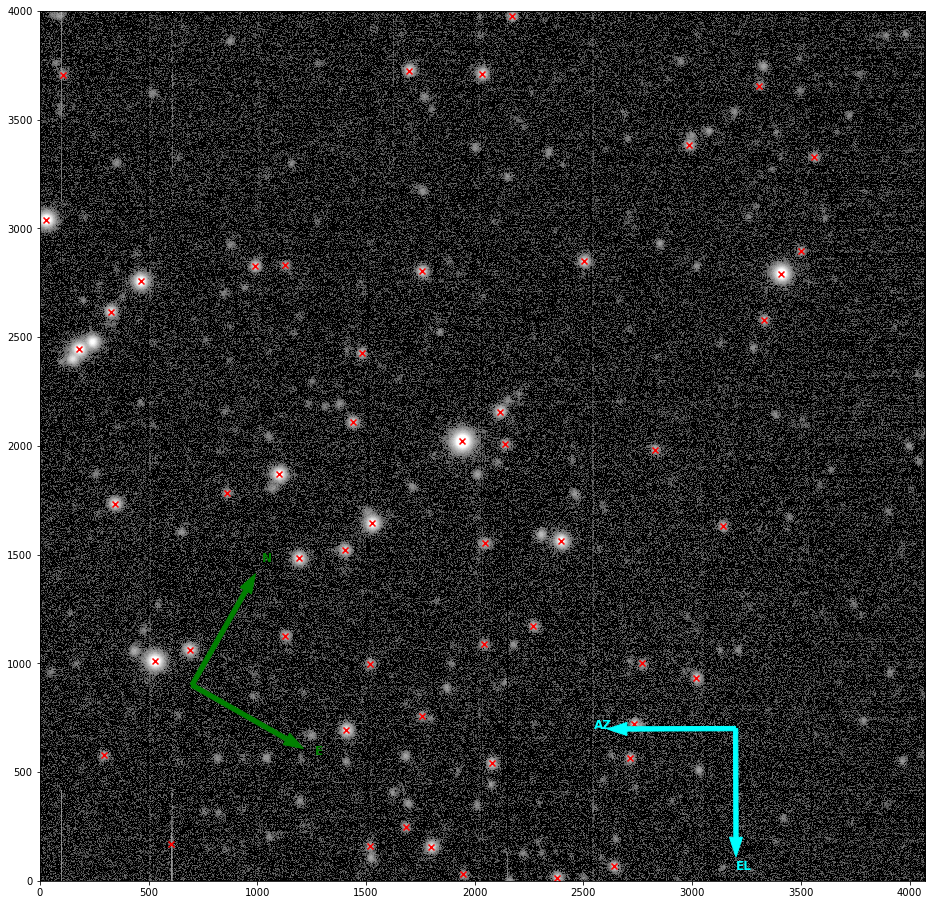

In [24]:
Ncenter = (700, 900)
Nlength = 500.0
NcenterAzEl = (3200, 700)
Nlabel = 650.0
yShift = 150.0

plt.figure(figsize=(16,16))
arr = exp.image.array
arr = np.clip(arr, 1, 100000) # This image has some negative values, and this removes them
img = plt.imshow(arr, norm=LogNorm(vmin=1, vmax=1000),  interpolation='Nearest', cmap='gray')

plt.scatter(cat['base_SdssCentroid_x'],cat['base_SdssCentroid_y']\
            ,color='red', marker='x')
rotpa = Angle(mData['ROTPA']*u.deg)
plt.arrow(Ncenter[0],Ncenter[1], -Nlength*np.sin(rotpa), Nlength*np.cos(rotpa),\
    color='green', width = 20)
plt.text(Ncenter[0]-Nlabel*np.sin(rotpa),Ncenter[1]+Nlabel*np.cos(rotpa), 'N', \
    color='green', fontsize=12, weight='bold')
plt.arrow(Ncenter[0],Ncenter[1], Nlength*np.cos(rotpa), Nlength*np.sin(rotpa),\
    color='green', width = 20)
plt.text(Ncenter[0]+Nlabel*np.cos(rotpa),Ncenter[1]+Nlabel*np.sin(rotpa), 'E', \
    color='green', fontsize=12, weight='bold')

el = Angle(mData['ELSTART'] * u.deg)
az = Angle(mData['AZSTART'] * u.deg)
dec = Angle(mData['DECSTART'] * u.deg)
sinTheta =  np.cos(location.lat) / np.cos(dec) * np.sin(az)
theta = Angle(np.arcsin(sinTheta))
rotAzEl = rotpa - theta - Angle(90.0 * u.deg)   
print(theta.deg, rotpa.deg, rotAzEl.deg)
plt.arrow(NcenterAzEl[0],NcenterAzEl[1], -Nlength*np.sin(rotAzEl), Nlength*np.cos(rotAzEl),\
    color='cyan', width = 20)
plt.text(NcenterAzEl[0]-Nlabel*np.sin(rotAzEl),NcenterAzEl[1]+Nlabel*np.cos(rotAzEl), 'EL', \
    color='cyan', fontsize=12, weight='bold')
plt.arrow(NcenterAzEl[0],NcenterAzEl[1], Nlength*np.cos(rotAzEl), Nlength*np.sin(rotAzEl),\
    color='cyan', width = 20)
plt.text(NcenterAzEl[0]+Nlabel*np.cos(rotAzEl),NcenterAzEl[1]+Nlabel*np.sin(rotAzEl), 'AZ', \
    color='cyan', fontsize=12, weight='bold')


plt.ylim(0,4000)
#plt.savefig('/project/cslage/AuxTel/offsets/2021060900352_ZeroLL.png')

In [7]:
ast = AstrometryNet()
ast.api_key = 'xxawwhvleirxcswx'


In [8]:
AstrometryNet.show_allowed_settings()

allow_commercial_use: type 'str', default value d, allowed values ('d', 'y', 'n')
allow_modifications: type 'str', default value d, allowed values ('d', 'y', 'n')
center_dec: type 'float', default value None, allowed values (-90, 90)
center_ra: type 'float', default value None, allowed values (0, 360)
crpix_center: type 'bool', default value None, allowed values ()
downsample_factor: type 'int', default value None, allowed values (1,)
parity: type 'int', default value None, allowed values (0, 2)
positional_error: type 'float', default value None, allowed values (0,)
publicly_visible: type 'str', default value y, allowed values ('y', 'n')
radius: type 'float', default value None, allowed values (0,)
scale_err: type 'float', default value None, allowed values (0, 100)
scale_est: type 'float', default value None, allowed values (0,)
scale_lower: type 'float', default value None, allowed values (0,)
scale_type: type 'str', default value None, allowed values ('ev', 'ul')
scale_units: type '

In [ ]:
sources = sourceCatalog.asAstropy()
sources.keep_columns(['base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_CircularApertureFlux_3_0_instFlux'])
sources.sort('base_CircularApertureFlux_3_0_instFlux', reverse=True)
# Keep just the 17 bright sources
#sources.remove_rows(slice(17, 53, 1))
    
image_width = 4072
image_height = 4000
scale_units = 'arcsecperpix'
scale_type='ev' # ev means submit estimate and % error
scale_est = 0.095
scale_err = 2.0
center_ra = mData['RA']
center_dec = mData['DEC']
radius = 0.5
wcs_header = ast.solve_from_source_list(sources['base_SdssCentroid_x'], sources['base_SdssCentroid_y'],
                                        image_width, image_height, scale_units=scale_units,
                                        scale_type=scale_type, scale_est=scale_est, scale_err=scale_err,
                                        center_ra=center_ra, center_dec=center_dec, radius=radius,
                                        solve_timeout=240)

In [17]:
mData['DATE']

'2021-06-10T02:53:08.700'

In [18]:
mData['OBJECT']

'HD175944'